# Tutorial 3: Interaction cutoffs and energy nonconservation

## Physics 7810, Spring 2020

## T3.1 - Truncation effects for interacting particles in a central force potential

In Tutorial 2, you wrote an MD simulation program for $N$ interacting particles in a central force potential. This simulation code had no interaction cutoff, so the cost of computing pair interactions was $O(N^2)$.

In this tutorial, we'll introduce interaction cutoffs, a step toward achieving $O(N)$ computational complexity, and we'll quantify the effects of pair potential truncation on energy conservation.

Modify your simulation code to introduce an interaction cutoff distance $r_c$, so that the pair interaction potential now has the form:

$$
u_{\rm int}(r_{ij}) = \left\{
\begin{array}{ll}
a r_{ij}^{-k}, & r_{ij} < r_c \\
0, & r_{ij} \geq r_c
\end{array}
\right..
$$

For this exercise, take $k = 6$ and assume that $a$ is positive (repulsive $r^{-6}$ pair interaction). Take the central force potential to be harmonic $n = 2$.

First, with no trunction of the pair potential, adjust the integration timestep and total kinetic energy so that very good energy conservation is achieved over long simulation times (this may require a judicious choice of initial conditions). Plot the total energy $E$ as a function of $t$ and measure the relative root-mean-squared (rms) fluctuation in total energy over the course of a long simulation, where the relative rms fluctuation in energy is defined as

$$
\frac{\langle \delta E^2 \rangle^{1/2}}{\langle E \rangle} = \frac{\langle (E - \langle E \rangle)^2 \rangle^{1/2}}{\langle E \rangle},
$$

and where the angle brackets denote a time average.

Recall that

$$
\langle \delta E^2 \rangle = \langle (E - \langle E \rangle)^2 \rangle = \langle E^2 - 2 E \langle E \rangle + \langle E \rangle^2 \rangle
= \langle E^2 \rangle - \langle E \rangle^2
$$

Now repeat this simulation for various values of $r_c$. Plot $E$ as a function of $t$ and measure $\langle \delta E^2 \rangle^{1/2} / \langle E \rangle$ for each value of $r_c$. What impact does potential truncation have on energy conservation? Does imposing an interaction cutoff lead to long-term energy drift?

### Solution

To quantify the influence of imposing potential truncation, we develop a method `quantify_cutoff` below to calculate the RMSF of the trajectory of a MD simulation given the parameters specified in `Tutorial_03.yml`, as show below. 
```yml
# Molecular dynamics simulation parameters
N_particles: 4
N_steps: 1000
dt: 0.001
m: 1 # the mass of the particle (all the same)
n: 2 # the order of the total external energy
u: 1 # the coefficient of the total external energy
k: 6 # the order of the pairwise potential 
a: 1 # the coefficient of pariwise potential
r_c: 0 # the distance cutoff for the interaction potential (r_c = 0 : no truncation)
box_length: 3
epsilon: 1  # epsilon in LJ potential
sigma: 1    # signma in LJ potential

print_freq: 1
dimension: 2
potential: 'central'
PBC: 'no'
coords_method: 'lattice'  
velo_method: 'random'
```

In [1]:
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.MD_NVE import *

def quantify_cutoff(r_c, plot=False, nsteps=None):
    mdp = Initialization('Tutorial_03.yml')
    MD = MolecularDynamics(mdp)
    MD.r_c = r_c
    if nsteps is not None:
        MD.N_steps = nsteps
    MD.verlet_integration(MD.velocities, MD.coords)
    TA = TrajAnalysis(MD, 'Tutorial_03_traj.yml')
    RMSF = TA.calculate_RMSF(TA.E_total)
    
    if plot is True:
        TA.plot_2d(TA.E_total, 'Total Energy')
        TA.plot_xy_traj()
        print('RMSF: %s' % RMSF)
    
    return RMSF

To observe the influence that energy trunaction has on the energy conservation, we plot the RMSF value as a function of cutoff distance. As shown below, when the cut of distnace is around 2.15, the RMSF is nearly zero, indicating that the energy is still well-conserved given this cutoff distance and number of steps. 

Optimal cutoff distance:  2.13
RMSF corresponding to the optimal cutoff:  2.0768972237761115e-07


Text(0.5,1,'RMSF as a function of cutoff distance')

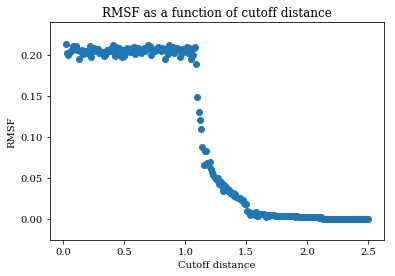

In [2]:
%matplotlib inline
r_c = np.arange(0.01, 2.51, 0.01)
RMSF = []
optimal_found = False

for i in r_c:
    rmsf = quantify_cutoff(i)
    RMSF.append(rmsf)
    if rmsf < 0.00001 and optimal_found is False and i != 0:
        optimal_found = True
        print('Optimal cutoff distance: ', i)
        print('RMSF corresponding to the optimal cutoff: ', rmsf)
    
plt.figure()
plt.scatter(r_c[1:], RMSF[1:])
plt.xlabel('Cutoff distance')
plt.ylabel('RMSF')
plt.title('RMSF as a function of cutoff distance')

To see if the energy drifts away in a long simulation with cutoff distance of 2.15, we increase the number of steps from 1000 to 20000. As shown below,  

RMSF: 2.052873473989425e-08


2.052873473989425e-08

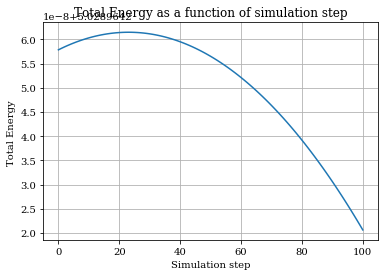

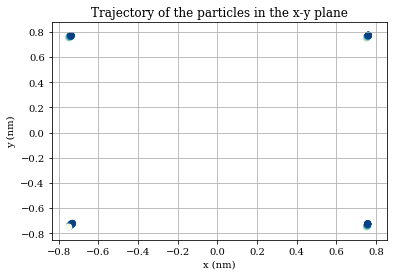

In [4]:
quantify_cutoff(2.15, plot=True, nsteps=100)